In [89]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [112]:
import fabio,pyFAI


In [113]:
ls Aarhus/


dia_cool_001-[phosphor]_fiji.tif  lab6_rt_001.tif
image2.png                        lab6_rt_001.xy
image.png                         large2.svg
lab6_rt_001.azim                  large3.svg
lab6_rt_001.dat                   large.png
lab6_rt_001-mask.edf              large.svg
lab6_rt_001.npt                   mask.edf
lab6_rt_001.npt_old               powder1.png
lab6_rt_001-[phosphor]_fiji.tif   powder2.png
lab6_rt_001.poni                  ReadMe.txt
lab6_rt_001.poni_old              si_cool_003-[phosphor]_fiji.tif


In [114]:
img = fabio.open("Aarhus/lab6_rt_001.tif").data
msk1 = fabio.open("Aarhus/lab6_rt_001-mask.edf").data
ai = pyFAI.load("Aarhus/lab6_rt_001.poni")
imshow(numpy.log(img))
print(ai)

Detector Aarhus	 Spline= None	 PixelSize= 2.500e-05, 2.500e-05 m
Wavelength= 2.070000e-11m
SampleDetDist= 3.011596e-01m	PONI= 6.591954e-03, -1.108204e-03m	rot1=-0.018199  rot2= 0.010729  rot3= 0.000025 rad
DirectBeamDist= 301.227mm	Center: x=174.927, y=392.951 pix	Tilt=1.210 deg  tiltPlanRotation= 30.524 deg


/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [116]:
q,I_nc = ai.integrate1d(img,10000, mask=msk1,method="splitpixel", correctSolidAngle=False, radial_range=(0, 100),polarization_factor=0.9)
plot(q,I_nc)
q_c,I_c = ai.integrate1d(img,10000, mask=msk1,method="splitpixel", correctSolidAngle=True, radial_range=(0, 100),polarization_factor=0.9)
plot(q_c,I_c)

#close('all')

In [121]:
tth,I_tth = ai.integrate1d(img,10000, mask=msk1,method="splitpixel", correctSolidAngle=True, polarization_factor=0.9, unit="2th_deg")
print(ai.wavelength)
numpy.savetxt("/tmp_14_days/kieffer/Aarhus.csv", numpy.vstack((tth,I_tth)).T,delimiter=',')

2.07e-11


In [95]:
#dataset from LUND ...

In [96]:
ls Lund/*.edf

Lund/mask.edf          Lund/thetascan2_2.edf  Lund/thetascan2_4.edf
Lund/thetascan2_1.edf  Lund/thetascan2_3.edf  Lund/thetascan2_5.edf


In [97]:
import glob
msk = fabio.open("Lund/mask.edf").data
images = glob.glob("Lund/thetascan*.img")
images.sort()
print(images)
imgs = []
mon = []
for i in images:
    im = fabio.open(i)
    im.data[im.data<0] = 0
    imgs.append(im.data)
    mon.append(float(im.header["Exposure time in sec"]))
ais = [pyFAI.load(i[:-3]+"poni") for i in images]
for ai in ais: 
    ai.detector.mask=msk


['Lund/thetascan_1_1.img', 'Lund/thetascan_2_1.img', 'Lund/thetascan_3_1.img', 'Lund/thetascan_4_1.img', 'Lund/thetascan_5_1.img']


area_pixel=12.413954202591414 area_sum=12.415176249867736, Error= -9.844141974252653e-05
area_pixel=12.388782395580456 area_sum=12.390622514446058, Error= -0.0001485310506590111
area_pixel=20.160486407579487 area_sum=20.168776654523, Error= -0.000411212645166961
area_pixel=0.627155295959902 area_sum=3.0714733948826733, Error= -3.8974686408118155


<IPython.core.display.Javascript object>


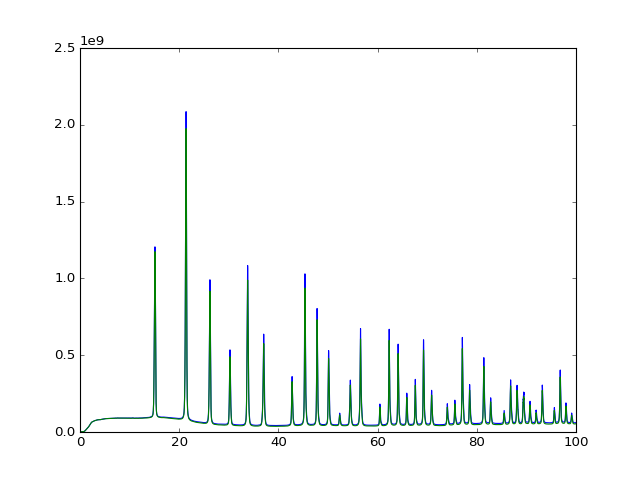

area_pixel=12.413954202591414 area_sum=12.415176249867736, Error= -9.844141974252653e-05
area_pixel=12.388782395580456 area_sum=12.390622514446058, Error= -0.0001485310506590111
area_pixel=20.160486407579487 area_sum=20.168776654523, Error= -0.000411212645166961
area_pixel=0.627155295959902 area_sum=3.0714733948826733, Error= -3.8974686408118155


In [98]:
from pyFAI.multi_geometry import MultiGeometry
mg = MultiGeometry(ais, radial_range=(0, 100), wavelength=1e-10, unit="q_nm^-1")
plot(*mg.integrate1d(imgs, 10000,monitors=mon, polarization_factor=0.9))
plot(*mg.integrate1d(imgs, 10000,monitors=mon, polarization_factor=None))

In [99]:
mon

[10.0, 16.0, 22.0, 28.0, 34.0]

In [100]:
#Correct for solid angle while histogramming

In [158]:
npt = 10000
sum_I = numpy.zeros(npt, dtype=numpy.float64) #Sum intensities corrected for polarization but not solid angle
sum_O = numpy.zeros(npt, dtype=numpy.float64) #Sum solid angle
polarization_factor = 0.9
EPS = 1e-100
for ai, data, monitor in zip(ais, imgs, mon):
    resI = ai.integrate1d(data, npt=npt,
                         correctSolidAngle=False,
                         polarization_factor=polarization_factor,
                         radial_range=(0,100),
                         method="splitpixel", unit="q_nm^-1", safe=True)
    resO = ai.integrate1d(ai.solidAngleArray(absolute=True), npt=npt,
                         correctSolidAngle=False,
                         #polarization_factor=polarization_factor,
                         radial_range=(0,100),
                         method="splitpixel", unit="q_nm^-1", safe=True)
    sum_I += resI.sum / monitor
    sum_O += resO.sum

norm = numpy.maximum(sum_O, EPS)
invalid = sum_O <= EPS
I_O = sum_I / norm
I_O[invalid] = 0


area_pixel=12.413954202591414 area_sum=12.415176249867736, Error= -9.844141974252653e-05
area_pixel=12.388782395580456 area_sum=12.390622514446058, Error= -0.0001485310506590111
area_pixel=20.160486407579487 area_sum=20.168776654523, Error= -0.000411212645166961
area_pixel=0.627155295959902 area_sum=3.0714733948826733, Error= -3.8974686408118155
area_pixel=12.413954202591414 area_sum=12.415176249867736, Error= -9.844141974252653e-05
area_pixel=12.388782395580456 area_sum=12.390622514446058, Error= -0.0001485310506590111
area_pixel=20.160486407579487 area_sum=20.168776654523, Error= -0.000411212645166961
area_pixel=0.627155295959902 area_sum=3.0714733948826733, Error= -3.8974686408118155


In [156]:
plot(resI.radial, I_O)

In [159]:
idx_min = abs(resI.radial - 40).argmin()
idx_max = I_O[resI.radial<20].argmax()
print(idx_min, idx_max)
I_mg_scaled = (I_O-I_O[idx_min])/(I_O[idx_max]-I_O[idx_min])
plot(resI.radial, I_mg_scaled, label="Lund")

3999 1511


In [160]:
idx_min = abs(q_c - 40).argmin()
idx_max = I_c[q_c<20].argmax()
print(idx_min, idx_max)
I_c_scaled = (I_c-I_c[idx_min])/(I_c[idx_max]-I_c[idx_min])
plot(q_c, I_c_scaled, label="Aarhus")
legend()

3999 1508


In [122]:
#Test with data from ID28

In [128]:
id28_images = glob.glob("ID28/*.cbf")
id28_images.sort()
print(id28_images)
id28_imgs = [fabio.open(i).data for i in id28_images]
id28_ais = [pyFAI.load(i[:-3]+"poni") for i in id28_images]


['ID28/det130_g0_0001p.cbf', 'ID28/det130_g17_0001p.cbf', 'ID28/det130_g45_0001p.cbf']


<IPython.core.display.Javascript object>


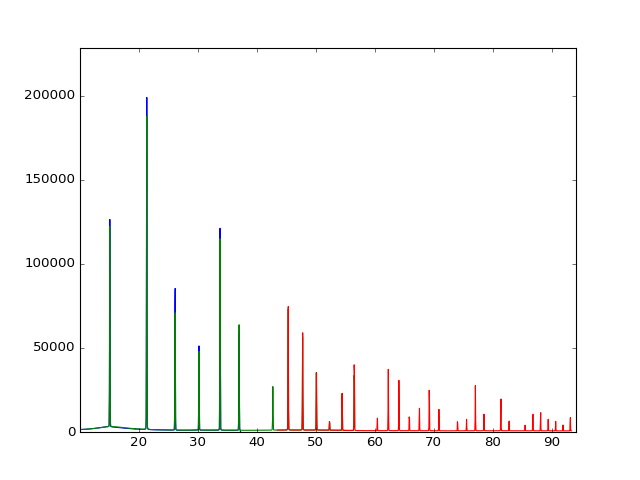

In [129]:
clf()
for i,a in zip(id28_imgs,id28_ais):
    plot(*a.integrate1d(i,1000))

In [131]:
id28_mg = MultiGeometry(id28_ais, radial_range=(0, 100), unit="q_nm^-1")
qr, Ir = id28_mg.integrate1d(id28_imgs, 10000)

In [132]:
npt = 10000
sum_I = numpy.zeros(npt, dtype=numpy.float64) #Sum intensities corrected for polarization but not solid angle
sum_O = numpy.zeros(npt, dtype=numpy.float64) #Sum solid angle
EPS = 1e-100
for ai, data in zip(id28_ais, id28_imgs):
    resI = ai.integrate1d(data, npt=npt,
                         correctSolidAngle=False,
                         radial_range=(0,100),
                         method="splitpixel", unit="q_nm^-1", safe=True)
    resO = ai.integrate1d(ai.solidAngleArray(absolute=True), npt=npt,
                         correctSolidAngle=False,
                         radial_range=(0,100),
                         method="splitpixel", unit="q_nm^-1", safe=True)
    sum_I += resI.sum
    sum_O += resO.sum

norm = numpy.maximum(sum_O, EPS)
invalid = sum_O <= EPS
I_O = sum_I / norm
I_O[invalid] = 0
qc = resI.radial
Ic = I_O

<IPython.core.display.Javascript object>


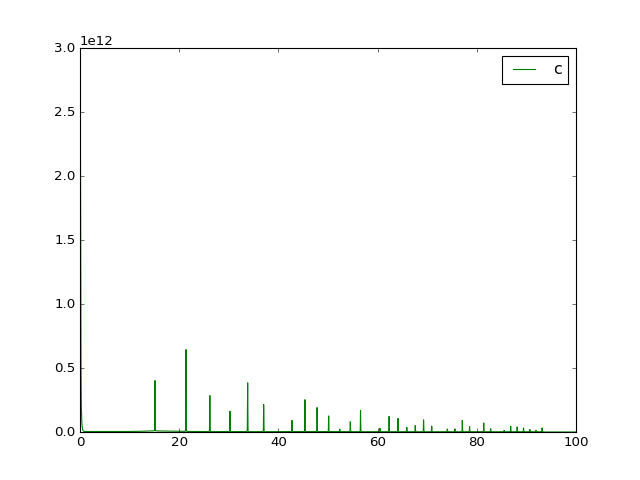

In [142]:
#plot(qr,Ir,"-r",label="mg")
plot(qc,Ic,"-g",label="c")
legend()

3999 1511
2854942865.56 401767763828.0 140.727076774


<IPython.core.display.Javascript object>


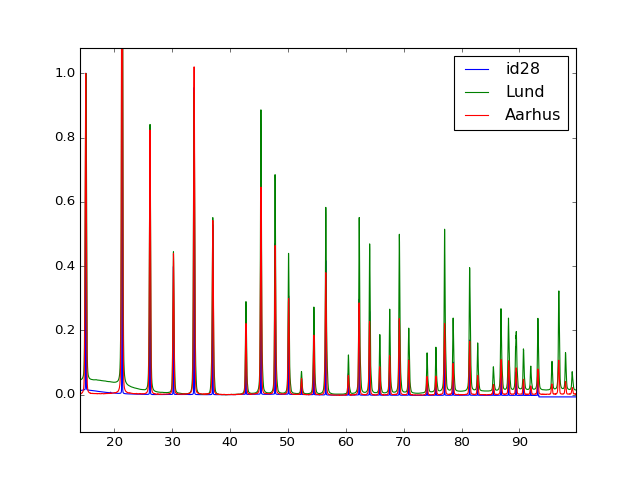

In [157]:
idx_min = abs(qc - 40).argmin()
idx_max = (Ic[numpy.logical_and(qc>10,qc<20)]).argmax() + (qc<10).sum()
print(idx_min, idx_max)
print(Ic[idx_min],Ic[idx_max], Ic[idx_max]/Ic[idx_min])
Ic_scaled = (Ic-Ic[idx_min])/(Ic[idx_max]-Ic[idx_min])
plot(qc, Ic_scaled , label="id28")
legend()